# Analysis of the RCNN results

In this notebook you will find every results obtained by our model. In this section, 2 models will be compared : Trained_RCNN.pth and Trained_RCNN_2.pth.  
More informations below

<span style="color:red">Cells in red should not be runned</span>

## 0. Load modules


In [1]:
# Core Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Operating System Interaction
import os
import sys

# Machine Learning Frameworks
import torch
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader

from helper_analysis import *

# Data Transformation and Augmentation (not all of these transformations were finally used)
from torchvision.transforms import Compose, RandomHorizontalFlip, RandomRotation, \
    RandomVerticalFlip, ColorJitter, RandomAffine, RandomPerspective, RandomResizedCrop, \
    GaussianBlur, RandomAutocontrast
from torchvision.transforms import functional as F

# Model Building and Initialization
import torch.nn as nn
from torch.nn.init import kaiming_normal_

# Data Loading and Dataset Handling
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, Subset
from PIL import Image

# Cross-Validation and Metrics
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, roc_curve, auc, accuracy_score
from scipy.special import expit as sigmoid

# Visualization and Display
from matplotlib.animation import FuncAnimation
from matplotlib.colors import Normalize
from IPython.display import HTML

# Miscellaneous
import random
from tqdm import tqdm

## 1. Import models

### 1.1 Declare data path

In [17]:
# For Google Colab, mount Google Drive, for local environments, get local path (github)

# Change with the appropriate path. Log in into Drive and create the folders with the data

if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')

    #folder0_path = '... your google path to .../data0'
    #folder1_path = '... your google path to .../data1'
    #folder0_test_path = '... your google path to .../data0_test'
    #folder1_test_path = '... your google path to .../data1_test'
    #folder0_valid_path = '... your google path to .../data0_val'
    #folder1_valid_path = '... your google path to .../data1_val'


else:
    # For local environments like VS Code
    folder0_path = '../data/data separated/data0'
    folder1_path = '../data/data separated/data1'
    folder0_test_path = '../data/data separated/data0_test'
    folder1_test_path = '../data/data separated/data1_test'
    folder0_valid_path = '../data/data separated/data0_val'
    folder1_valid_path = '../data/data separated/data1_val'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1.2 Declare the class and the transforms

In [3]:
class TensorTransforms:
    def __init__(self, rotate_angle=30):
        self.rotate_angle = rotate_angle

    def random_horizontal_flip(self, x):
        if random.random() > 0.5:
            return torch.flip(x, [2])  # Flip along width
        return x

    def random_vertical_flip(self, x):
        if random.random() > 0.5:
            return torch.flip(x, [1])  # Flip along height
        return x

    def random_rotation(self, x):
        # Random rotation in increments of 90 degrees for simplicity
        k = random.randint(0, 3)  # 0, 90, 180, or 270 degrees
        return torch.rot90(x, k, [1, 2])  # Rotate along height and width

    def __call__(self, x):
        x = self.random_horizontal_flip(x)
        x = self.random_vertical_flip(x)
        x = self.random_rotation(x)
        return x

class NPZDataset(Dataset):
    def __init__(self, data_dir, augment=True, mean=None, std=None):
        self.data_dir = data_dir
        self.augment = augment
        self.files = [f for f in os.listdir(data_dir) if self._check_file_shape(f)]
        self.transform = TensorTransforms()
        self.mean = mean
        self.std = std

    def _check_file_shape(self, file):
        file_path = os.path.join(self.data_dir, file)
        data = np.load(file_path)['arr_0']
        return data.shape == (166, 166, 30)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = os.path.join(self.data_dir, self.files[idx])
        data = np.load(file_path)['arr_0']
        data = np.moveaxis(data, -1, 0)  # Move channel to first dimension

        data = torch.from_numpy(data).float()  # Convert to PyTorch tensor

        if self.augment: #way to improve is to add to the data
            data = self.transform(data) #there we should concatenate both data and data_transformed

        if self.mean is not None and self.std is not None:
            data = np.clip(data, a_min=None, a_max= 1000)
            data = (data - self.mean) / self.std


        label = 1.0 if 'data1' in self.data_dir else 0.0

        return data, np.float32(label)

In [4]:
mean_data = 50.564544677734375
std_data = 49.94772720336914

### 1.3 Get the data, declare the Dataloaders

In [18]:
train_data1 = NPZDataset(folder1_path, mean=mean_data, std=std_data, augment=True)
train_data0 = NPZDataset(folder0_path, mean=mean_data, std=std_data, augment=True)
train_dataset = torch.utils.data.ConcatDataset([train_data1, train_data0])

test_data1 = NPZDataset(folder1_test_path, mean=mean_data, std=std_data, augment=False)
test_data0 = NPZDataset(folder0_test_path, mean=mean_data, std=std_data, augment=False)
test_dataset = torch.utils.data.ConcatDataset([test_data1, test_data0])

valid_data1 = NPZDataset(folder1_valid_path, mean=mean_data, std=std_data, augment=False)
valid_data0 = NPZDataset(folder0_valid_path, mean=mean_data, std=std_data, augment=False)
validate_dataset = torch.utils.data.ConcatDataset([valid_data1, valid_data0])

In [19]:
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
valid_loader = DataLoader(validate_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

## 2. Define the RCNN

In [20]:
class RCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.max_pool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.layer1 = nn.Sequential(
            nn.Conv2d(30,64,kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64,64,kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64,128,kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(128,128,kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(128,256,kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.layer6 = nn.Sequential(
            nn.Conv2d(256,256,kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.layer7 = nn.Sequential(
            nn.Conv2d(256,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.layer8 = nn.Sequential(
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        # hidden_size is an hyperparameter to be adjusted
        # try augmenting num_layers
        self.lstm = nn.LSTM(input_size=12800, hidden_size=256, num_layers=1, batch_first=True)

        self.classifier = nn.Sequential(
            nn.Linear(256,128),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(128,32),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(32,1),
            #nn.Sigmoid()     # don't include it as it is already included in BCELogitLoss (BCELoss is less stable)
        )

        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.max_pool(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.max_pool(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.max_pool(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.max_pool(out)
        out = self.layer8(out)
        out = self.layer8(out)
        out = self.max_pool(out)
        out = out.view(out.size(0),-1)
        lstm_out, _ = self.lstm(out)
        out = self.classifier(lstm_out)

        return out

    def graph(self): #for visualization and debugging
        return nn.Sequential(self.layer1,self.layer2,self.maxPool,self.layer3,self.layer4,self.maxPool,self.layer5,self.layer6,self.maxPool,self.layer7,self.layer8, self.maxPool,self.layer8,self.layer8,self.maxPool,self.classifier)

## 3. Compare the results from the grid search for the hyperparameter optimization

### 3.1 Import the dictionnary containing the parameter specification, the accuracy and the F1 score for all 18 combinations

In [ ]:
import json

json_file_path = 'result_cv_final.json'

# Open the JSON file and load the data into a Python dictionary
with open(json_file_path, 'r') as file:
    result_dict = json.load(file)

# Now, 'data_dictionary' contains the content of your JSON file as a Python dictionary
print(result_dict)
a = int(len(result_dict) / 4)

### 3.2 Plot the results (1 plot per learning rate)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


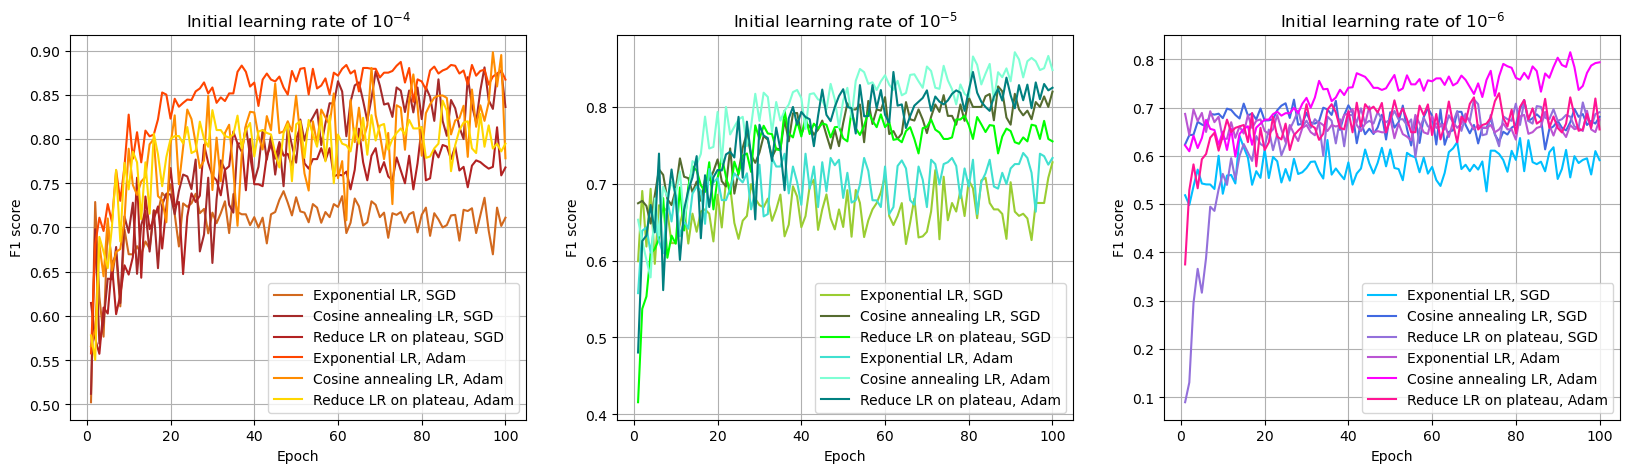

In [ ]:
num_epochs = 100
t_test = np.arange(1, num_epochs + 1)
clr_lst = ['chocolate', 'brown', 'firebrick', 'orangered', 'darkorange', 'gold',
           'yellowgreen', 'darkolivegreen', "lime", "turquoise", "aquamarine", "teal",
            'deepskyblue', 'royalblue', 'mediumpurple', 'mediumorchid', 'fuchsia', 'deeppink']

lr_set = set()

for i in range(a):
    hyperparams_name = f"hyperparams_{i}"
    hyperparams = result_dict[hyperparams_name]

    lr_set.add(str(hyperparams[0]))

if len(lr_set) == 1:

  fig, axs = plt.subplots()

  for i in range(a):

    f1_valid_name = f"f1_valid_{i}"
    f1_vals = result_dict[f1_valid_name]

    lr, scheduler_type, optimizer = get_param(result_dict, i)

    axs.plot(t_test, f1_vals, color=clr_lst[i], label= lr + ", " + scheduler_type + ", " + optimizer)

  axs.legend()
  axs.set_title('F1 score on the validation set')
  axs.set_xlabel('Epoch')
  axs.set_ylabel('F1 score')

  plt.show()

elif len(lr_set) == 2:

  fig, axs = plt.subplots(1, 2, figsize=(20, 5))
  fig.suptitle('Validation F1 score')

  for i in range(int(a/2)):

    f1_valid_name = f"f1_valid_{i}"
    f1_vals = result_dict[f1_valid_name]

    lr, scheduler_type, optimizer = get_param(result_dict, i)

    axs[0].plot(t_test, f1_vals, color=clr_lst[i], label= scheduler_type + ", " + optimizer)

  axs[0].grid(True)
  axs[0].legend()
  axs[0].set_title(f'Initial learning rate of {1e-4}')
  axs[0].set_xlabel('Epoch')
  axs[0].set_ylabel('F1 score')

  for i in range(int(a/2), int(a)):

    f1_valid_name = f"f1_valid_{i}"
    f1_vals = result_dict[f1_valid_name]

    lr, scheduler_type, optimizer = get_param(result_dict, i)

    axs[1].plot(t_test, f1_vals, color=clr_lst[i], label= scheduler_type + ", " + optimizer)

  axs[1].grid(True)
  axs[1].legend()
  axs[1].set_title(f'Initial learning rate of {1e-5}')
  axs[1].set_xlabel('Epoch')
  axs[1].set_ylabel('F1 score')

  plt.show()

elif len(lr_set) == 3:

  fig, axs = plt.subplots(1, 3, figsize=(20, 5))

  for i in range(int(a/3)):

    f1_valid_name = f"f1_valid_{i}"
    f1_vals = result_dict[f1_valid_name]

    lr, scheduler_type, optimizer = get_param(result_dict, i)

    axs[0].plot(t_test, f1_vals, color=clr_lst[i], label= scheduler_type + ", " + optimizer)

  axs[0].grid(True)
  axs[0].legend()
  axs[0].set_title("Initial learning rate of $10^{-4}$")
  axs[0].set_xlabel('Epoch')
  axs[0].set_ylabel('F1 score')

  for i in range(int(a/3), int(2*a/3)):

    f1_valid_name = f"f1_valid_{i}"
    f1_vals = result_dict[f1_valid_name]

    lr, scheduler_type, optimizer = get_param(result_dict, i)

    axs[1].plot(t_test, f1_vals, color=clr_lst[i], label= scheduler_type + ", " + optimizer)

  axs[1].grid(True)
  axs[1].legend()
  axs[1].set_title("Initial learning rate of $10^{-5}$")
  axs[1].set_xlabel('Epoch')
  axs[1].set_ylabel('F1 score')


  for i in range(int(2*a/3), int(3*a/3)):
    f1_valid_name = f"f1_valid_{i}"
    f1_vals = result_dict[f1_valid_name]

    lr, scheduler_type, optimizer = get_param(result_dict, i)

    axs[2].plot(t_test, f1_vals, color=clr_lst[i], label= scheduler_type + ", " + optimizer)

  axs[2].grid(True)
  axs[2].legend()
  axs[2].set_title("Initial learning rate of $10^{-6}$")
  axs[2].set_xlabel('Epoch')
  axs[2].set_ylabel('F1 score')

  fig.savefig('figures/crossval.eps', format='eps', bbox_inches='tight')
  plt.show()



## 4. Import the trained model

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if 'google.colab' in sys.modules:
    from google.colab import drive

    model_path = '/content/drive/My Drive/Colab Notebooks/CS433-project2/Trained_RCNN.pth'
    model2_path = '/content/drive/My Drive/Colab Notebooks/CS433-project2/Trained_RCNN_2.pth'
else:
  model_path = './Trained_RCNN.pth'
  model2_path = './Trained_RCNN_2.pth'

model = torch.load(model_path, map_location=device)
model2 = torch.load(model2_path, map_location=device)

model.eval()
model2.eval()

model = model.to(device)
model2 = model2.to(device)

## 5. F1 score vs threshold for the 2 best models

<span style="color:red">This cell will take some time to run if no gpu can be used !  
Approx 2 hours for cpu ! Do not run if you don't have any gpu available  
Results of this code are shown in the output of the cells below</span>

In [23]:
thresholds = np.linspace(0, 1, 100)
criterion = torch.nn.BCEWithLogitsLoss()
print(device)

""" Model 1 """

model_f1 = np.zeros(len(thresholds))
model_acc = np.zeros(len(thresholds))

for i,t in enumerate(thresholds):
    _, acc, pred, target, _ = test(model, valid_loader, criterion, device, t)
    f1 = f1_score(target, pred, average='binary')
    print(f"model 1, threshold: {t:.3}, f1 = {f1:.3}, acc = {acc:.3} \n")
    model_f1[i] = f1
    model_acc[i] = acc



""" Model 2 """

model2_f1 = np.zeros(len(thresholds))
model2_acc = np.zeros(len(thresholds))

for i,t in enumerate(thresholds):
    _, acc, pred, target, _ = test(model2, valid_loader, criterion, device, t)
    f1 = f1_score(target, pred, average='binary')
    print(f"model 2, threshold: {t:.3}, f1 = {f1:.3}, acc = {acc:.3} \n")
    model2_f1[i] = f1
    model2_acc[i] = acc


cuda
model 1, threshold: 0.0, f1 = 0.667, acc = 0.5 

model 1, threshold: 0.0101, f1 = 0.845, acc = 0.821 

model 1, threshold: 0.0202, f1 = 0.864, acc = 0.849 

model 1, threshold: 0.0303, f1 = 0.876, acc = 0.865 

model 1, threshold: 0.0404, f1 = 0.879, acc = 0.869 

model 1, threshold: 0.0505, f1 = 0.881, acc = 0.873 

model 1, threshold: 0.0606, f1 = 0.887, acc = 0.881 

model 1, threshold: 0.0707, f1 = 0.887, acc = 0.881 

model 1, threshold: 0.0808, f1 = 0.894, acc = 0.889 

model 1, threshold: 0.0909, f1 = 0.893, acc = 0.889 

model 1, threshold: 0.101, f1 = 0.889, acc = 0.885 

model 1, threshold: 0.111, f1 = 0.892, acc = 0.889 

model 1, threshold: 0.121, f1 = 0.891, acc = 0.889 

model 1, threshold: 0.131, f1 = 0.891, acc = 0.889 

model 1, threshold: 0.141, f1 = 0.895, acc = 0.893 

model 1, threshold: 0.152, f1 = 0.895, acc = 0.893 

model 1, threshold: 0.162, f1 = 0.894, acc = 0.893 

model 1, threshold: 0.172, f1 = 0.894, acc = 0.893 

model 1, threshold: 0.182, f1 = 0.89

In [ ]:
best_idx1 = np.argmax(model_f1)
best_idx2 = np.argmax(model2_f1)

print(f"The higher F1-score of model 1 is {model_f1[best_idx1]:.4} and corresponds to a threshold value of {thresholds[best_idx1]:.4}. \n ")
print(f"The higher F1-score of model 2 is {model2_f1[best_idx2]:.4} and corresponds to a threshold value of {thresholds[best_idx2]:.4}. \n ")


The higher F1-score of model 1 is 0.8949 and corresponds to a threshold value of 0.1414. 
 
The higher F1-score of model 2 is 0.8635 and corresponds to a threshold value of 0.1717. 
 


### 5.1 Plot the results: F1 score and accuracy vs threshold for each model

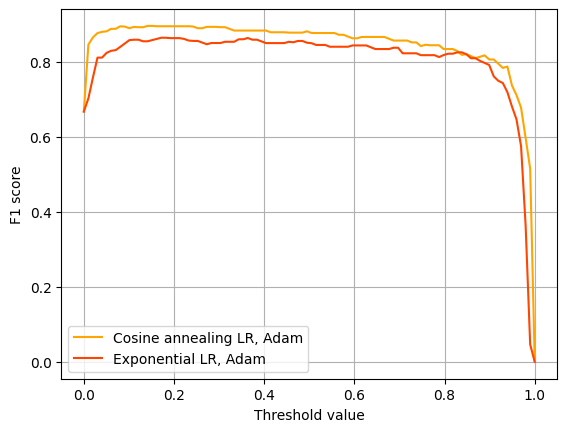

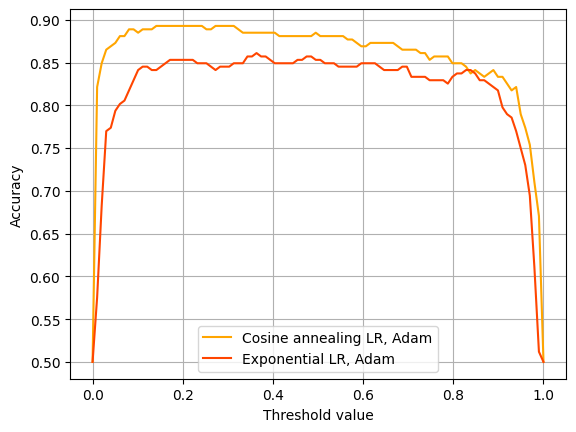

In [24]:
""" F1 score """

fig, axs = plt.subplots()

axs.plot(thresholds, model_f1, color='orange', label='Cosine annealing LR, Adam')
axs.plot(thresholds, model2_f1, color='orangered', label='Exponential LR, Adam')

axs.set_xlabel('Threshold value')
axs.set_ylabel('F1 score')
axs.grid(True)
axs.legend()

fig.savefig('figure/f1_vs_threshold.eps', format='eps')


""" Accuracy """

fig2, axs2 = plt.subplots()

axs2.plot(thresholds, model_acc, color='orange', label='Cosine annealing LR, Adam')
axs2.plot(thresholds, model2_acc, color='orangered', label='Exponential LR, Adam')

axs2.set_xlabel('Threshold value')
axs2.set_ylabel('Accuracy')
axs2.grid(True)
axs2.legend()

## 6. Define, run and analyze best model (on test set now that this model is the final version!!)

In [ ]:
# Define final model and threshold for further analysis
best_model = model
best_thres = 0.1
criterion = torch.nn.BCEWithLogitsLoss()

# Run the final model on test data and get the final F1 score
loss, accuracy, pred, target, _ = test(best_model, test_loader, criterion, device, best_thres)
test_f1 = f1_score(target, pred, average='binary')

In [ ]:
print(f"Accuracy of the model on the test set: {accuracy:.4}")
print(f"Loss of the model on the test set: {loss:.4}")
print(f"F1 score on test set: {test_f1:.4}")

Accuracy of the model on the test set: 0.9231
Loss of the model on the test set: 0.1945
F1 score on test set: 0.9286


## 6.1 Confusion matrix

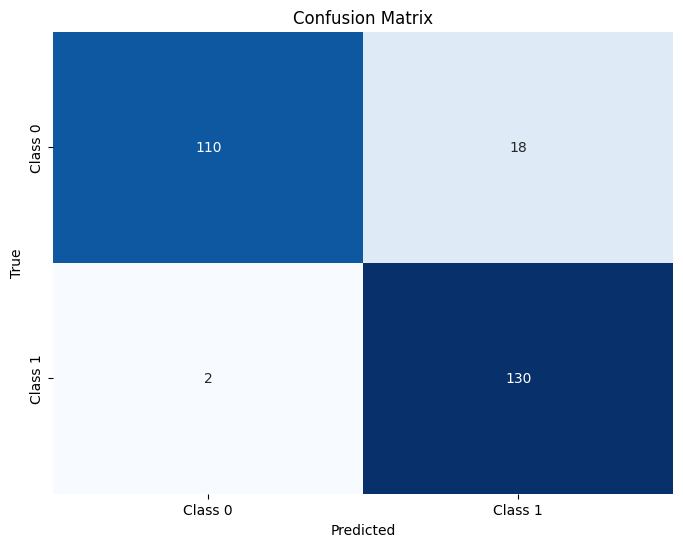

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(target, pred)

# Create a heatmap for visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Class 0", "Class 1"],
            yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


## 6.2 Misclassified images

In [ ]:
#!pip install sunpy         # if running in colab, otherwise sunpy should be installed
import sunpy

from torchvision import transforms
import sunpy.visualization.colormaps as cm

In [ ]:
# Set the model to evaluation mode
model = model.to(device)
threshold = 0.1

misclassified_images = []
true_labels = []
predicted_labels = []

count=0
itera=0
# Iterate through the test set
with torch.no_grad():
        for data, target in test_loader:
            itera+=1
            #MOVING THE TENSORS TO THE CONFIGURED DEVICE
            data, target = data.to(device), target.to(device).unsqueeze(1).float()

            #FORWARD PASS
            output = model(data)
            # PREDICTIONS
            pred = (torch.sigmoid(output) >= threshold).float().view(-1).cpu()
            target=target.view(-1).cpu()

            # Identify misclassified images
            misclassified_mask = pred != target
            count+=misclassified_mask.sum()


            misclassified_images.extend(data[misclassified_mask])
            true_labels.extend(target[misclassified_mask])
            predicted_labels.extend(pred[misclassified_mask])

print(f"There is {count} missclassified images")
# Convert lists to PyTorch tensors
misclassified_images = torch.stack(misclassified_images)
true_labels = torch.stack(true_labels)
predicted_labels = torch.stack(predicted_labels)

# Assuming you have a function to reverse normalization if applied during data preprocessing
# Replace reverse_normalize with your actual function
# Example:
reverse_normalize = transforms.Compose([transforms.Normalize(mean=0, std=(1/62.7087)),
                                        transforms.Normalize(mean=-51.6644, std=1)])



There is 20 missclassified images


### 6.2.2 Generate .gif animations of the 20 misclassified images

In [ ]:
fig, ax = plt.subplots(dpi=400, figsize=(5, 4))

# Function to update the animation frame
def update(frame):
    im.set_array(image[frame, :, :])
    return im,

# loop over all misclassified images

for i in range(1):

    # Get the image sequence and the corresponding label and prediction
    image = misclassified_images[i].cpu().numpy()
    true_label = true_labels[i].item()
    predicted_label = predicted_labels[i].item()

    # Define the image normalization
    vmin, vmax = np.percentile(image, [1, 99.9])
    norm = Normalize(vmin=vmin, vmax=vmax)

    # Initialize the animation with an empty frame
    im = ax.imshow(image[0,: , :], cmap='sdoaia304', norm=norm)
    ax.set_title(f'True: {true_label}, Predicted: {predicted_label}')

    # Create the animation
    ani = FuncAnimation(fig, update, frames=30, interval=100, blit=True)  # 100 milliseconds per frame

    # Save in .gif format
    print(f"saving figure {i+1}")
    ani.save(f"figures/animation_{i+1}.gif", writer='pillow', fps=10, dpi=400)


## 6.3 ROC curve

In [ ]:
from sklearn.metrics import roc_curve, auc

loss, accuracy, pred, target, _ = test(best_model, test_loader, criterion, device, best_thres)

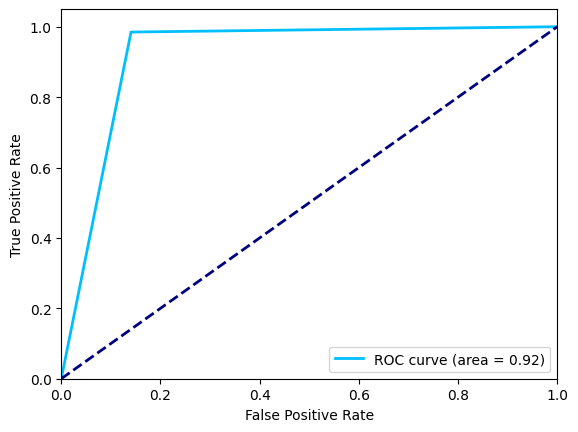

In [ ]:
# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(target, pred)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='deepskyblue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

plt.savefig('figures/ROC.eps', format='eps')
plt.show()